In [61]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sns
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn, optim
from torch.utils.data import SubsetRandomSampler


In [28]:
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,56,48,44,98,98,99,63,59,60,43,...,31,31,37,56,60,69,56,63,75,1
1,74,78,69,91,88,83,198,206,157,102,...,185,198,201,169,178,181,116,120,122,1
2,6,9,9,3,6,6,8,11,10,6,...,49,68,65,55,74,71,39,55,54,1
3,156,165,169,161,172,176,149,160,164,163,...,114,121,124,125,131,136,137,142,145,1
4,75,71,73,16,48,34,166,141,116,67,...,38,47,59,59,87,90,84,106,118,1


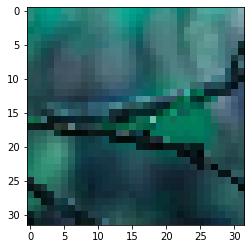

In [29]:
plt.imshow(np.array(test.iloc[500][0:3072]).reshape(32,32,3))

In [50]:
y = np.array(data['3072'])
X = np.array(data.drop('3072', axis = 1))

<AxesSubplot:ylabel='Count'>

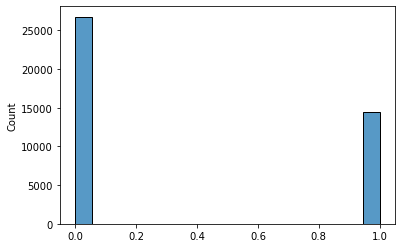

In [51]:
sns.histplot(y)

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.15, random_state = 42)

In [54]:
X_test

array([[ 66,  74,  88, ...,  32,  36,  40],
       [104, 148, 185, ..., 114, 163, 185],
       [  7,  12,  12, ...,  21,  39,  25],
       ...,
       [122, 132, 143, ...,  61,  63,  67],
       [169, 118,  52, ..., 110, 102, 108],
       [218, 221, 221, ..., 106, 108, 107]])

In [55]:
# prepare data to use with pytorch
class PathMNIST(Dataset):
    def __init__(self, mode="train", transform=None):

      if mode == "train":
        x, y = X_train, y_train
      elif mode == "val":
        x, y = X_val, y_val
      elif mode == "test":
        x, y = X_test, y_test
      else:
        raise ValueError("Invalid mode.")

  
      self._x = x
      self._y = y.squeeze()
      self._transform = transform

    def __len__(self):
      return self._x.shape[0]

    def __getitem__(self, idx):
      item = self._x[idx]
      label = self._y[idx]
      if self._transform is not None:
        item = self._transform(item)
      item = item.flatten()
      return item, label

In [56]:
train_set = PathMNIST(mode="train")
val_set = PathMNIST(mode="val")
test_set = PathMNIST(mode="test")


train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)
test_loader = DataLoader(test_set, batch_size=1)

In [57]:
train_set._x[0].shape

(3072,)

<AxesSubplot:ylabel='Count'>

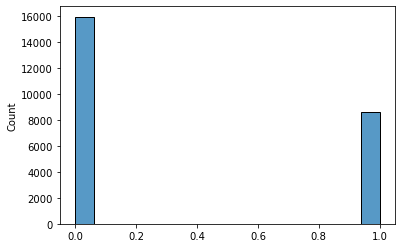

In [58]:
sns.histplot(train_set._y)

## Preparação para o pytorch

In [69]:
num_epochs = 5

In [62]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [75]:
def show_accuracy(pred_list, label_list):
  correct = [0,0]
  total = [0,0]
  matrix = np.zeros((2,2))

  for i in range(len(pred_list)):
    matrix[label_list[i]][pred_list[i]]+=1
    if pred_list[i] == label_list[i]:
      correct[pred_list[i]]+=1
    total[label_list[i]] += 1

  acc = [100*(x/y) for x,y in zip(correct,total)]
  print('Accuracy of the network on the 10004 val images on each class:')
  print(acc)
  print('Total accuracy:',100*(sum(correct)/sum(total)),"%")
  plt.figure(figsize=(15,15))
  sns.heatmap(matrix,annot = True,cmap="YlGnBu")
  plt.show()

## Rede Neural

In [64]:
#Criando a primeira rede:
class MinhaRede(nn.Module):
    #Rede com 4 hidden layers
  def __init__(self, tam_entrada):
    super(MinhaRede, self).__init__()

    # Definir a arquitetura
    self.rede = nn.Sequential(
        nn.Linear(tam_entrada, 256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Linear(128,32),
        nn.ReLU(),
        nn.Linear(32,2)
    )
  

  def forward(self, imagem):
    saida = self.rede(imagem)
    return saida

In [65]:
tam_entrada = 3 * 32 * 32
rede = MinhaRede(tam_entrada).to(device)

In [66]:
#inicializando os pesos com o metodo Xavier
def initialize_weights(m):
  if isinstance(m, nn.Linear):
      nn.init.xavier_uniform(m.weight)
      m.bias.data.fill_(0.01)

rede.apply(initialize_weights)

<ipython-input-66-4a47e4f753db>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


MinhaRede(
  (rede): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [70]:
optimizer = optim.SGD(rede.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0009)
criterion = nn.CrossEntropyLoss().to(device)

In [71]:

def forward(mode, loader):

  if mode == 'train':
    rede.train()
  else:
    rede.eval()
  
  epoch_loss = []
  pred_list, label_list = [], []

  for data, label in loader:
    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    out = rede(data.float()/255)
    loss = criterion(out, label.long())
    epoch_loss.append(loss.cpu().data)

    predicted=out.data.max(dim=1)[1].cpu().numpy()
    pred_list.append(predicted)
    label_list.append(label.cpu().numpy())

    if mode == 'train':
      loss.backward()
      optimizer.step()
  
  epoch_loss = np.asarray(epoch_loss)
  pred_list = np.asarray(pred_list).ravel()
  label_list = np.asarray(label_list).ravel()
  if mode != 'train':
    return pred_list, label_list
  print(mode, 'Loss:', epoch_loss.mean(), '+/-', epoch_loss.std())

In [76]:
for i in range(num_epochs):
  forward('train', train_loader)

train Loss: 0.6390704 +/- 0.054514017
train Loss: 0.6386296 +/- 0.05821273
train Loss: 0.6368956 +/- 0.05965511
train Loss: 0.6358286 +/- 0.054876868
train Loss: 0.63431376 +/- 0.055931445


In [80]:
print(device)

cpu


Accuracy of the network on the 10004 val images on each class:
[100.0, 0.0]
Total accuracy: 64.49292929292929 %


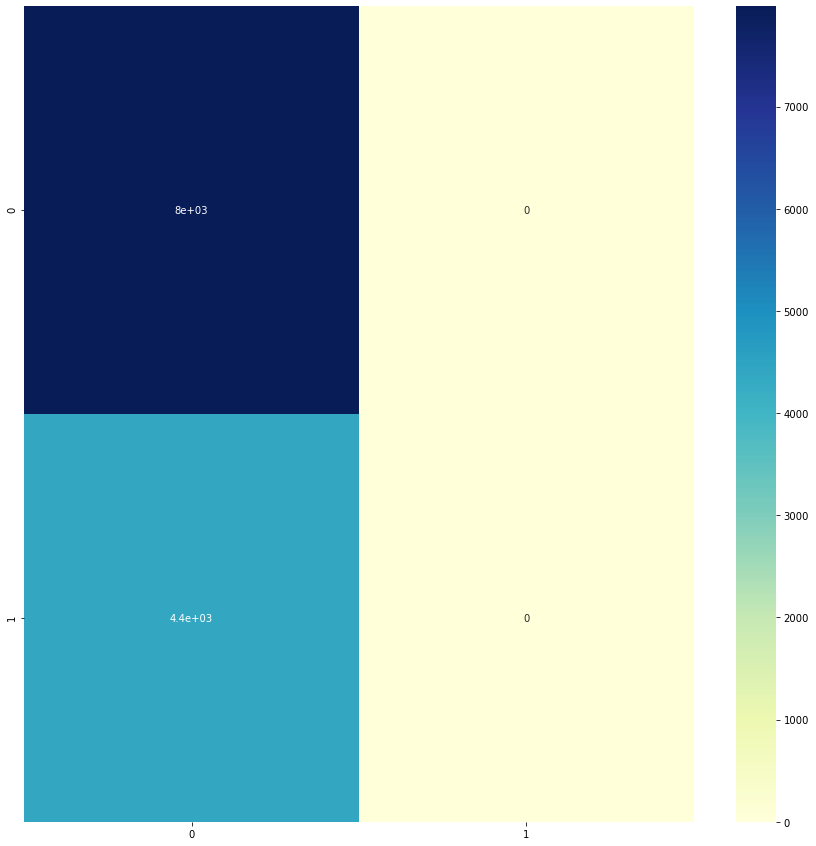

In [77]:
pred_list, label_list = forward('val', val_loader)
show_accuracy(pred_list, label_list)